In [1]:
import numpy as np
import pandas as pd
from Utilities import obsFrac, getMidnightNoonIdx
from MarkovSwitchingSSM import MarkovSwitchingSSM
import datetime
from scipy.stats import invwishart
from numpy.random import beta as beta_sample
from numpy.linalg import eig
from scipy.stats import multivariate_normal as mvn

In [2]:
colors = 2*[c["color"] for c in plt.rcParams["axes.prop_cycle"]]

## Feather data

In [183]:
# Info on what's available
feather_wsns = ["ktl", "grzl"]

# Choose a network
df_feather_ktl = pd.read_csv("../output/feather/%s.csv" % feather_wsns[0])
times = pd.to_datetime(df_feather_ktl["time"])

# Extract values
y_sd_raw = df_feather_ktl[["snowdepth_%i" % s for s in range(1, 12)]].values
y_t_raw = df_feather_ktl[["air_temp_%i" % s for s in range(1, 12)]].values
y_rh_raw = df_feather_ktl[["rel_humidity_%i" % s for s in range(1, 12)]].values

In [180]:
precips_raw = y_sd_raw[1:, :] - y_sd_raw[0:-1, :]

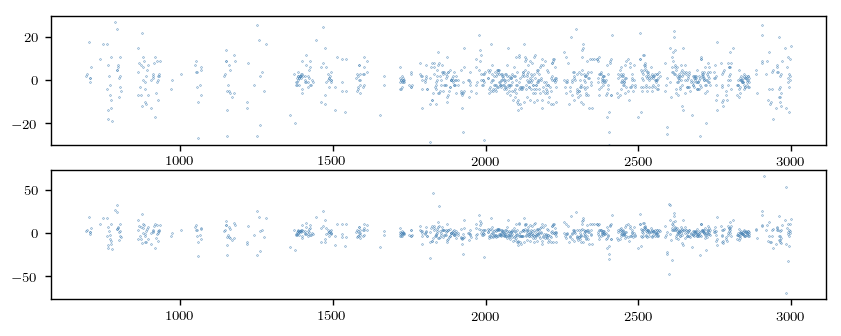

In [208]:
plt.figure(figsize=(8, 3))

plt.subplot(2, 1, 1)
plt.plot(precips_raw[12000:15000, 0], '.', markersize=0.5)
plt.ylim(-30, 30)

plt.subplot(2, 1, 2)
plt.plot(precips_raw[12000:15000, 0], '.', markersize=0.5)

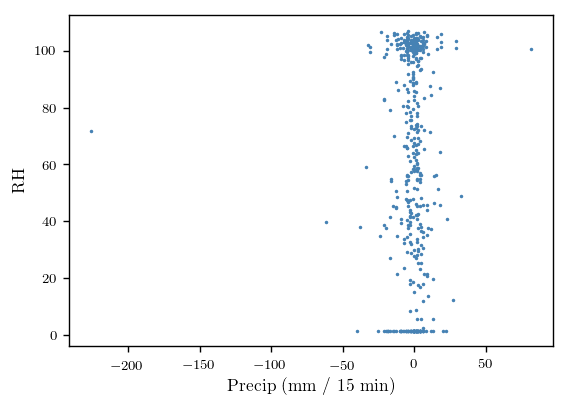

In [227]:
sensor = 7

plt.plot(precips_raw[:, sensor], y_rh_raw[:-1, sensor], '.', markersize=2)
plt.xlabel("Precip (mm / 15 min)")
plt.ylabel("RH")

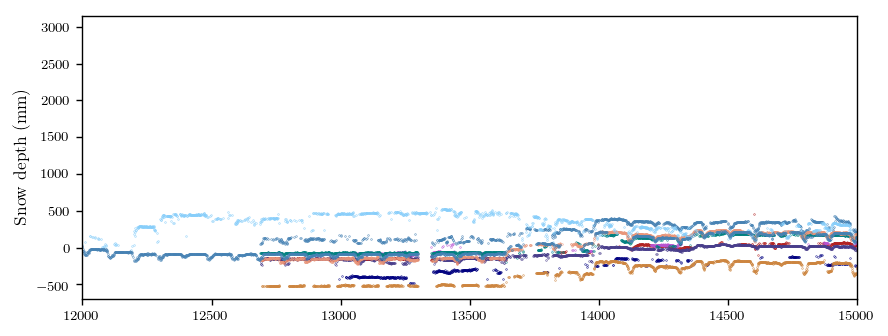

In [178]:
plt.figure(figsize=(8, 3))

plt.plot(y_sd_raw, '.', markersize=0.5)

plt.xlim(12000, 15000)
plt.ylabel("Snow depth (mm)")

## Other data (from Eric's github page)

In [136]:
Y_raw = np.loadtxt("../output/filled_test.csv")[:, 0:4]
T, N = Y_raw.shape

# Separate out summer data
ti_summer = 250
tf_summer = 400

# Number of summer observations
T_s = tf_summer - ti_summer

summer_data = Y_raw[ti_summer:tf_summer, :]

In [137]:
dt = 0.25
n_LF = 4

### Priors

In [138]:
### Weakly informative prior based on there appearing to be ~15 transitions between snowing and melting over about 15,000 observations
p_p = {"a": 0.9, "b": 0.1}
p_q = {"a": 0.9, "b": 0.1}

# Not clear what to use for hidden state's covariance...
p_Q = {"V_0": 500.0*np.identity(n_LF), "nu_0": n_LF + 2.0}
# Use augmented state transition matrix as prior for A
A_0 = np.asarray(np.bmat([[np.identity(n_LF/2), dt*np.identity(n_LF/2)], [np.zeros(2*[n_LF/2]), np.identity(n_LF/2)]]))
p_AQ = {"B_0": A_0, "lambda_0": np.identity(n_LF) * 5e4}

### Use summer data to put prior on R
nu_R = T_s + N + 1
R_0 = np.dot(np.nan_to_num(summer_data.T), np.nan_to_num(summer_data))
R_0 = np.diag(R_0.diagonal()) / (nu_R - N - 2) * (nu_R - N - 1)
p_R = {"V_0": R_0, "nu_0": nu_R}
# No idea what to use for C
C_0 = np.asarray(np.bmat([[np.identity(n_LF/2), np.zeros(2*[n_LF/2])], [np.identity(n_LF/2), np.zeros(2*[n_LF/2])]]))
lambda_C = np.identity(n_LF)
p_CR = {"B_0": C_0, "lambda_0": lambda_C}

### Snow depth should start off around 0
p_pi0_sigma = {"mu_0": np.zeros(n_LF), "Psi": np.identity(n_LF), "nu": n_LF + 2.0, "lambda": 1.0}

### Run the Gibbs sampler!

In [157]:
ti = tf_summer
tf = tf_summer+3000
n_samples = 50

ms_ssm = MarkovSwitchingSSM(Y_raw[ti:tf, :], 2, p_p, p_q, p_pi0_sigma, p_Q, p_AQ, p_R, p_CR)
results = ms_ssm.gibbs_sample(n_samples) # run

# Compute expected observations for each sample
y_samples = np.zeros([n_samples, tf-ti, N])

for s in range(N):
    for Cs, x_0, x_ts, n in zip(results["Cs"], results["x_0"], results["x_ts"], range(n_samples)):
        y_samples[n, :, s] = np.asarray([np.dot(Cs[0], x_t)[s] for x_t in x_ts])

### Plot results

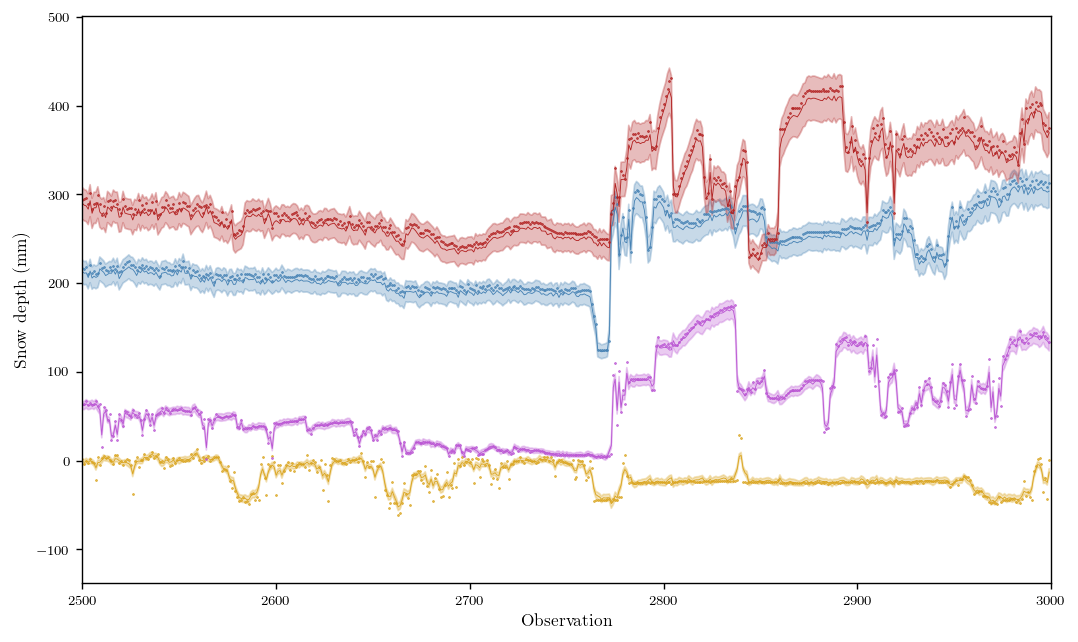

In [165]:
plt.figure(figsize=(10, 6))
    
# Compute posterior means and standard errors
y_means = np.mean(y_samples, axis=0)
y_errs = np.std(y_samples, axis=0) / np.sqrt(n_samples)

for s, c in zip(range(N), colors):
    # Plot mean of posterior
    plt.plot(y_means[:, s], color=c, linewidth=0.5)
    # Plot 3*standard error band
    plt.fill_between(range(tf-ti), y_means[:, s] - 3*y_errs[:, s], y_means[:, s] + 3*y_errs[:, s], color=c, alpha=0.3)

    # Plot data
    plt.plot(Y_raw[ti:tf, s], '.', color=c, markersize=1)

plt.xlim(2500, 3000)
plt.xlabel("Observation")
plt.ylabel("Snow depth (mm)")

### Testing Gibbs sampler by hand

In [41]:
s_0, s_ts, p, q, pi_0, sigma_0, As, Cs, Qs, Rs = ms_ssm._gibbs_sampler_init()

In [42]:
Cs[0]

array([[ -2.53107528,  -9.12711814,  11.6162066 ,  -6.65366244,
         15.57556649,   7.25836863,  -2.81600118,  15.07285195],
       [-11.4495463 ,  -1.82322975,  -7.54317398,  -7.16117628,
          8.16323002, -14.41782096, -10.62152737,  68.90658588],
       [-15.25223497,  -4.86632329, -15.49610208,  13.53965438,
          8.37326196,  -5.61059494,  -5.41943427,  12.59410813],
       [-16.65636267,  -7.29229941,  15.19525311,  -1.30872861,
          4.78445148, -13.00068428,  -0.54030975,   1.62389115],
       [ -1.76590974,  -0.57255858,  -2.63614946, -11.79176268,
          9.18239064,   6.75090801,   0.1358109 , -35.89462182],
       [  8.24558459, -12.09759704,  11.48367545,   1.81918647,
          3.62914573, -10.37902418,   1.50097259,  -2.61305839],
       [  1.78861603, -30.13390764,   2.11257702,  -6.09764521,
         -0.16495746,   4.16380147,  -2.16238789, -25.76366632],
       [  2.10625597,  33.70342595,  -5.37267435,   2.03296527,
          8.77400867,  -8.2153375

In [15]:
x_0, x_ts = ms_ssm.draw_xs(s_0, s_ts, pi_0, sigma_0, As, Cs, Qs, Rs)

In [10]:
s_0, s_ts = ms_ssm.draw_ss(x_0, x_ts, As, Cs, Qs, Rs, p, q)

In [11]:
np.zeros(10, dtype=int)[np.zeros(10, dtype=int)[0]]

0